In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import csv
import pandas as pd
import tqdm
import torch
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer

In [17]:
df = pd.read_csv('../data scraping/extracted_data.csv')

# Check if MPS is supported and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

df = df[df['model_size'] == '175b']
df

Using device: mps


,book_text,depth_3_summary,model_size,book_num,document_index
41944,"THE BIRTH OF A WOMAN-CHILD\n\n""Whose cradle's ...","Uncle Pros is helping Laurella, his sick niece...",175b,0,0
41945,selfish--said she'd like to know how I was goi...,"Laurella explains that her husband, Consadine,...",175b,0,1
41946,"rich, broken light from the cavernous fireplac...",Pros takes the cradle outside to get the last ...,175b,0,2
41947,"\n""Well, you go ask Pap to look in the green c...",Mavity sends Bud and Mandy Ann to ask her fath...,175b,0,3
41948,"she wants--ain't ye, Pretty?""\n\nAnd, having m...",Pros finishes repairing the cradle and places ...,175b,0,4
...,...,...,...,...,...
83883,"\nAlong the Paris streets, the death-carts rum...","Along the streets of Paris, death carts rumble...",175b,266,320
83884,"and faces are often turned up to some of them,...",The faces of the people are often turned up to...,175b,266,321
83885,"Defarge!""\n\n""She never missed before,"" says a...","The Vengeance calls out for Therese, but she d...",175b,266,322
83886,"and differing, have come together on the dark ...",The seamstress tells Sydney that she has an on...,175b,266,323


In [11]:
def get_first_5_summary_sentences(group):
    first_5_sentences = group.head(5)
    return first_5_sentences

# Apply the function to each group and reset the index
filtered_df = df.groupby('book_num').apply(get_first_5_summary_sentences).reset_index(drop=True)
filtered_df

,book_text,depth_3_summary,model_size,book_num,document_index
0,"THE BIRTH OF A WOMAN-CHILD\n\n""Whose cradle's ...","Uncle Pros is helping Laurella, his sick niece...",175b,0,0
1,selfish--said she'd like to know how I was goi...,"Laurella explains that her husband, Consadine,...",175b,0,1
2,"rich, broken light from the cavernous fireplac...",Pros takes the cradle outside to get the last ...,175b,0,2
3,"\n""Well, you go ask Pap to look in the green c...",Mavity sends Bud and Mandy Ann to ask her fath...,175b,0,3
4,"she wants--ain't ye, Pretty?""\n\nAnd, having m...",Pros finishes repairing the cradle and places ...,175b,0,4
...,...,...,...,...,...
745,"I. The Period\n\n\nIt was the best of times,\n...",It's 1775 in England and France. The king and ...,175b,266,0
746,"rustic mire, snuffed about by pigs, and rooste...","In England, there is a lack of order and prote...",175b,266,1
747,\nII. The Mail\n\n\nIt was the Dover road that...,A man walks up the Dover road on a Friday nigh...,175b,266,2
748,were very shy of being confidential on a short...,The guard of the Dover mail thinks to himself ...,175b,266,3


In [ ]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base').to(device)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

document_ids, document_embeddings = [], []
for i, item in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    # Tokenize the text and move inputs to the MPS device
    inputs = context_tokenizer(item["book_text"], return_tensors='pt', padding=True, truncation=True).to(device)
    
    # Perform the encoding
    embeddings = context_encoder(**inputs).pooler_output
    
    # Collect the results
    document_ids.append(item.name) 
    document_embeddings.append(embeddings.detach())  

In [5]:
document_embeddings = torch.stack(document_embeddings).squeeze()
document_embeddings

tensor([[ 6.4310e-02,  5.1082e-01, -3.4688e-01,  ..., -1.3058e-01,
          1.9109e-01, -2.9275e-01],
        [ 5.1724e-02,  6.4735e-02,  3.5823e-03,  ..., -2.1219e-01,
         -3.9279e-02, -2.6027e-01],
        [ 1.2122e-01,  6.9524e-01, -4.1303e-01,  ...,  1.1080e-01,
          2.7936e-01, -2.9228e-01],
        ...,
        [-1.7773e-02,  3.1759e-01,  1.4883e-01,  ..., -6.4625e-04,
          5.8568e-01, -1.6165e-01],
        [ 5.8647e-02,  2.8824e-01,  7.7362e-02,  ..., -1.3946e-01,
          1.4672e-01,  2.0716e-01],
        [-2.4728e-01,  1.9122e-01, -1.2486e-01,  ..., -5.5524e-02,
          1.9567e-01,  9.6288e-02]], device='mps:0')

In [21]:
from collections import defaultdict
from model_helper import two_gram_overlap

def calculate_recall_at_k(similarity_scores, true_doc_id, k):
    top_k_indices = similarity_scores.topk(k=k).indices
    return true_doc_id in top_k_indices

# Recall@K results
recall_results = defaultdict(lambda: 0)
dpr_scores = []
two_gram_overlaps = []
two_gram_top_k = 10

question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base').to(device)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    query_inputs = question_tokenizer(row["depth_3_summary"], return_tensors='pt', padding=True, truncation=True).to(device)
    query_embedding = question_encoder(**query_inputs).pooler_output

    # Compute dot product similarity and rank documents
    similarity_scores = torch.matmul(query_embedding, document_embeddings.T).squeeze()
    
    # Calculate two gram overlap
    top_k_results = similarity_scores.topk(k=two_gram_top_k)
    top_k_scores = top_k_results.values.detach().cpu().numpy() 
    top_k_indices = top_k_results.indices.detach().cpu().numpy()  

    top_k_context = [df.iloc[i]["book_text"] for i in top_k_indices]

    for i, context in enumerate(top_k_context):
        two_gram_score = two_gram_overlap(row["depth_3_summary"], context)
        dpr_scores.append(top_k_scores[i])  
        two_gram_overlaps.append(two_gram_score)

    # Update Recall@K metrics
    for k in range(1, 11):
        recall_results[k] += calculate_recall_at_k(similarity_scores, row.name, k)  

# Calculate average Recall@K over the dataset
for k in recall_results:
    recall_results[k] /= len(df)

print("Recall@K for K=1 to 10:", recall_results)


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4000/4000 [02:49<00:00, 23.57it/s]

Recall@K for K=1 to 10: defaultdict(<function <lambda> at 0x2b1eea700>, {1: 0.568, 2: 0.674, 3: 0.7205, 4: 0.7565, 5: 0.77925, 6: 0.796, 7: 0.81125, 8: 0.81875, 9: 0.8275, 10: 0.83425})


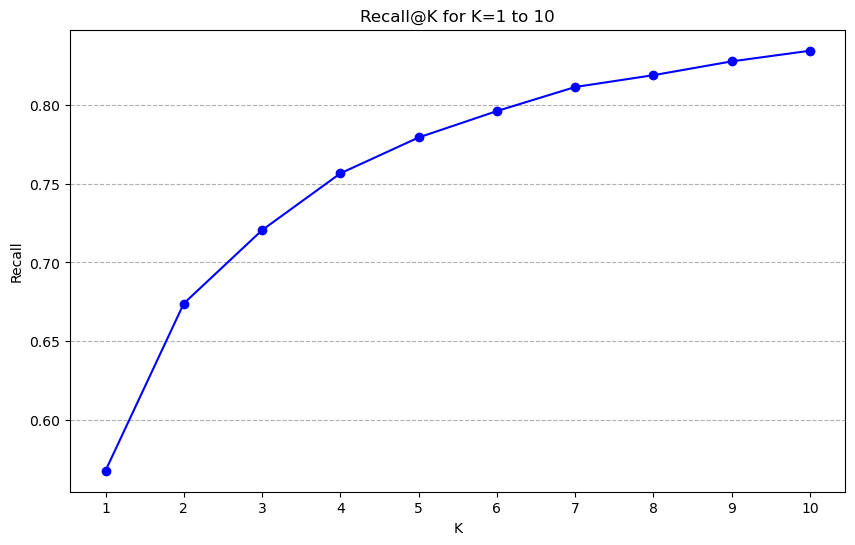

In [22]:
import matplotlib.pyplot as plt

ks = list(recall_results.keys())
recalls = list(recall_results.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ks, recalls, marker='o', linestyle='-', color='b')
plt.title('Recall@K for K=1 to 10')
plt.xlabel('K')
plt.ylabel('Recall')
plt.xticks(ks)
plt.grid(axis='y', linestyle='--')

plt.show()

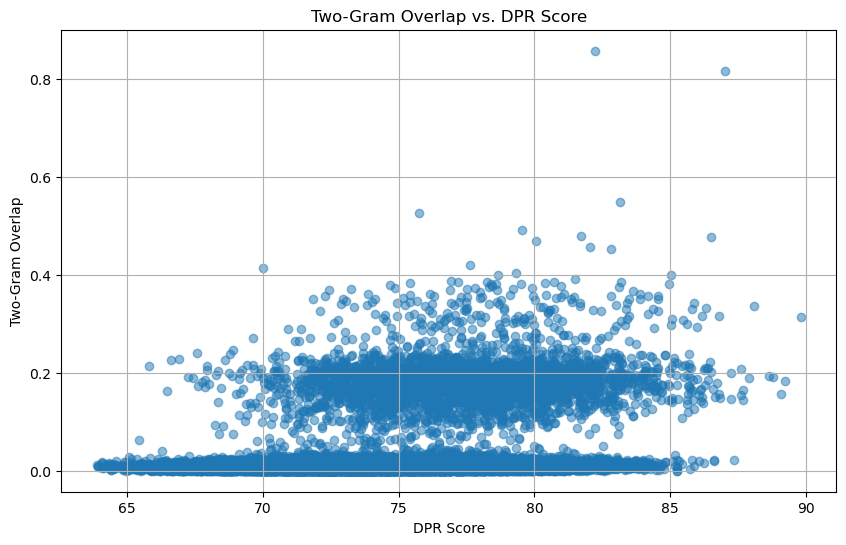

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(dpr_scores, two_gram_overlaps, alpha=0.5)
plt.title('Two-Gram Overlap vs. DPR Score')
plt.xlabel('DPR Score')
plt.ylabel('Two-Gram Overlap')
plt.grid(True)
plt.show()